In [2]:
###########################
#  Master thesis
# 
# UNIVERSITY: 
#  Faculty of Information Technology, Brno University of Technology
# 
# AUTHOR:
#  Aleš Kašpárek          <xkaspa48@stud.fit.vutbr.cz>
###########################

import json
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x : torch.Tensor):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.fc2(x)
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append([target])
    return torch.tensor(X, dtype=torch.float32).unsqueeze(1), torch.tensor(y, dtype=torch.float32)

In [3]:
RESULTS = {}

def train_fnc(config):  
    network_analytics = pd.read_csv('/home/ales/DIP/data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = config['input_size']
    hidden_size = 1
    num_layers = 1
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    for epoch in range(400):
        running_loss = .0
        model.train()
        
        for idx, (inputs,labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss
            
        train_loss = running_loss/len(train_loader)

        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())
                
            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss

    RESULTS[config['input_size']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 51):
    train_fnc({'input_size' : x})

with open('../outputs/lstm_input.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

2


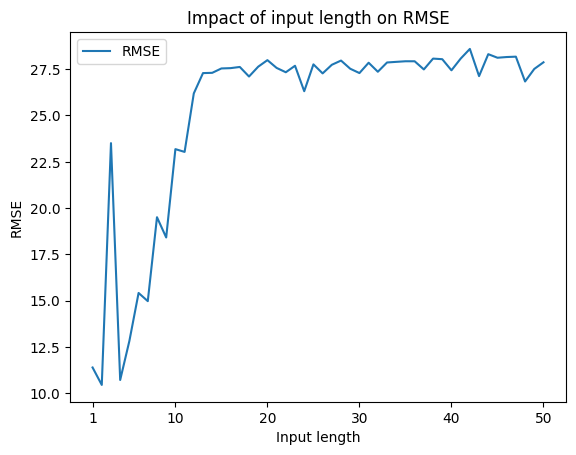

In [3]:
with open('../outputs/lstm_input.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
    
print(min(d, key=d.get))

plt.xlabel('Input length')
plt.ylabel('RMSE')
plt.title('Impact of input length on RMSE')
plt.plot(x, y, label='RMSE')
plt.xticks([1, 10, 20, 30, 40, 50])
plt.legend(loc='best')
plt.show()

In [10]:
RESULTS = {}

def train_fnc(config):  
    network_analytics = pd.read_csv('/home/ales/DIP/data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = 2
    num_layers = config['layers']
    hidden_size = 1
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    for epoch in range(400):
        running_loss = .0
        model.train()
        
        for idx, (inputs,labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss
            
        train_loss = running_loss/len(train_loader)

        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())
                
            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss

    RESULTS[config['layers']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 51):
    train_fnc({'layers' : x})

with open('../outputs/lstm_layers.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

1


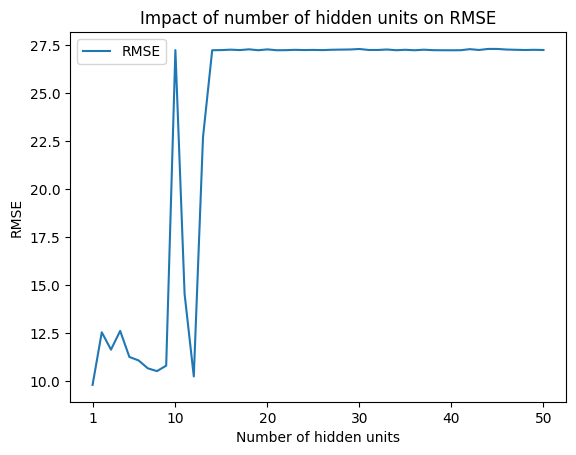

In [4]:
with open('../outputs/lstm_layers.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
print(min(d, key=d.get))
ticks = np.arange(1, len(x) + 1, 1)

plt.xlabel('Number of hidden units')
plt.title('Impact of number of hidden units on RMSE')
plt.ylabel('RMSE')
plt.xticks([1, 10, 20, 30, 40, 50])
plt.plot(x, y, label='RMSE')
plt.legend(loc='best')
plt.show()

In [12]:
RESULTS = {}

def train_fnc(config):  
    network_analytics = pd.read_csv('/home/ales/DIP/data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = 2
    hidden_size = config['hidden']
    num_layers = 1
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    for epoch in range(400):
        running_loss = .0
        model.train()
        
        for idx, (inputs,labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss
            
        train_loss = running_loss/len(train_loader)

        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())
                
            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss

    RESULTS[config['hidden']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 51):
    train_fnc({'hidden' : x})

with open('../outputs/lstm_layers.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

5


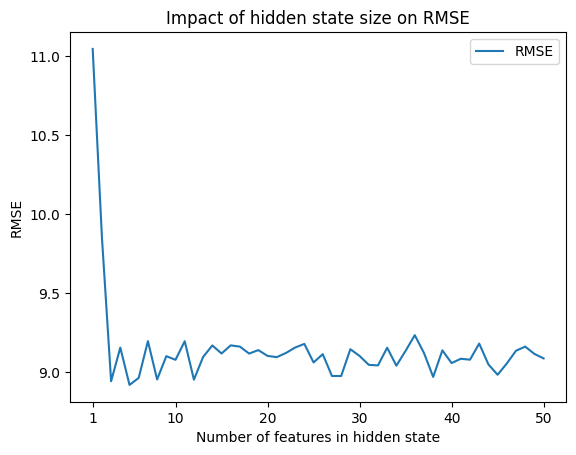

In [5]:
with open('../outputs/lstm_hidden.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
    
print(min(d, key=d.get))

plt.xlabel('Number of features in hidden state')
plt.title('Impact of hidden state size on RMSE')
plt.ylabel('RMSE')
plt.xticks([1, 10, 20, 30, 40, 50])
plt.plot(x, y, label='RMSE')
plt.legend(loc='best')
plt.show()